In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monkeypox-dataset-daily-updated/Monkey_Pox_Cases_Worldwide.csv
/kaggle/input/monkeypox-dataset-daily-updated/Worldwide_Case_Detection_Timeline.csv
/kaggle/input/monkeypox-dataset-daily-updated/Daily_Country_Wise_Confirmed_Cases.csv


In [2]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.4 MB/s eta 0:00:00


In [3]:
worldwide = pd.read_csv('/kaggle/input/monkeypox-dataset-daily-updated/Monkey_Pox_Cases_Worldwide.csv')            
detected = pd.read_csv('/kaggle/input/monkeypox-dataset-daily-updated/Worldwide_Case_Detection_Timeline.csv')  
confirmed = pd.read_csv('/kaggle/input/monkeypox-dataset-daily-updated/Daily_Country_Wise_Confirmed_Cases.csv')  

In [4]:
detected = detected.drop_duplicates()

In [5]:
detected

,Date_confirmation,Country,City,Age,Gender,Symptoms,Hospitalised (Y/N/NA),Isolated (Y/N/NA),Travel_history (Y/N/NA)
0,2022-05-06,England,London,NaN,NaN,rash,Y,Y,Y
1,2022-05-12,England,London,NaN,NaN,rash,Y,Y,N
2,2022-05-13,England,London,NaN,NaN,vesicular rash,N,Y,N
3,2022-05-15,England,London,NaN,male,vesicular rash,Y,Y,N
5,2022-05-15,England,London,NaN,male,vesicular rash,NaN,Y,N
...,...,...,...,...,...,...,...,...,...
5804,2022-06-30,Switzerland,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5806,2022-06-30,Argentina,Cordoba,25-29,male,"fever, headache, malaise",NaN,NaN,Y
5973,2022-07-01,Germany,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5998,2022-07-01,Austria,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
detected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 640 entries, 0 to 6026
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Date_confirmation        640 non-null    object
 1   Country                  640 non-null    object
 2   City                     230 non-null    object
 3   Age                      230 non-null    object
 4   Gender                   283 non-null    object
 5   Symptoms                 50 non-null     object
 6   Hospitalised (Y/N/NA)    96 non-null     object
 7   Isolated (Y/N/NA)        150 non-null    object
 8   Travel_history (Y/N/NA)  154 non-null    object
dtypes: object(9)
memory usage: 50.0+ KB


In [7]:
def plot_map(df,col):
    df = df[df[col]>0]
    fig = px.choropleth(df, locations="Country", locationmode='country names', 
                  color=col, hover_name="Country", 
                  title=col, hover_data=[col], height=800,width=1200, color_continuous_scale="peach")
    fig.show()

# Visualization

In [8]:
plot_map(worldwide, 'Confirmed_Cases')

In [9]:
confirmed_cases = worldwide[['Country','Confirmed_Cases']]

fig = px.bar(confirmed_cases.sort_values('Confirmed_Cases',ascending=False)[:20][::-1],x="Confirmed_Cases",y="Country",
             title="Top 20 Countries with Highest Number of Confirmed Cases",text='Confirmed_Cases',
             height=700,width=1200)
fig.show()

In [10]:
plot_map(worldwide, 'Suspected_Cases')

suspected_cases = worldwide[['Country','Suspected_Cases']]
fig = px.bar(suspected_cases.sort_values('Suspected_Cases',ascending=False)[:20][::-1],x="Suspected_Cases",y="Country",
             title="Top 20 Countries with Highest Number of Suspected Cases",text='Suspected_Cases',
             color_discrete_sequence=px.colors.qualitative.Light24,height=700,width=1200)
fig.show()

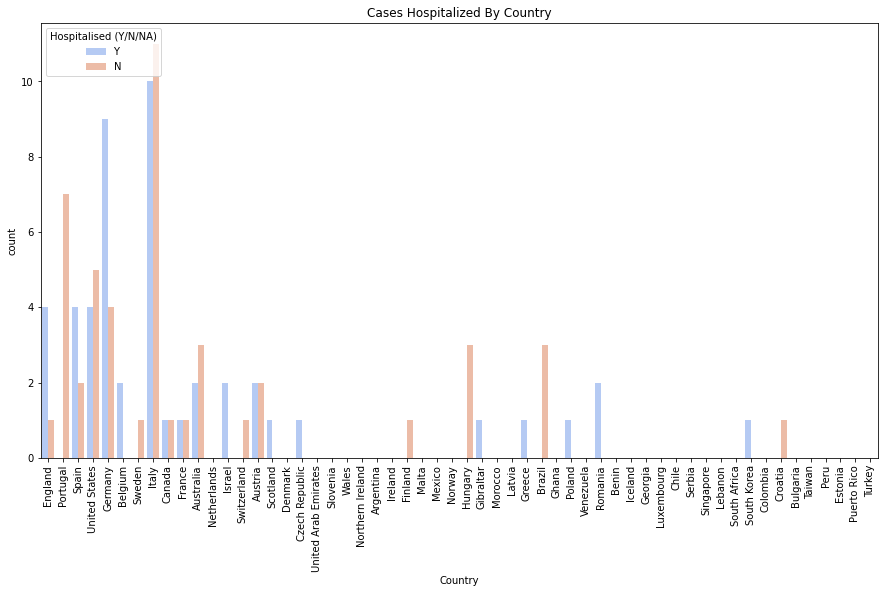

In [11]:
plt.figure(figsize = (15,8))
sns.countplot(x="Country", data=detected, hue = "Hospitalised (Y/N/NA)",palette="coolwarm")
plt.xticks(rotation = 90)
plt.title("Cases Hospitalized By Country")
plt.show()

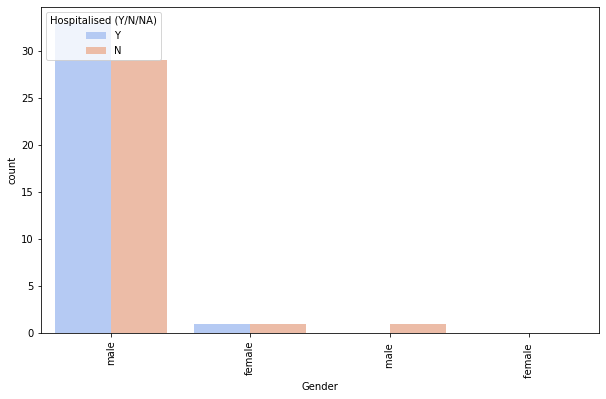

In [12]:
plt.figure(figsize = (10,6))
sns.countplot(x="Gender", data=detected, hue = "Hospitalised (Y/N/NA)",palette="coolwarm")
plt.xticks(rotation = 90)
plt.show()

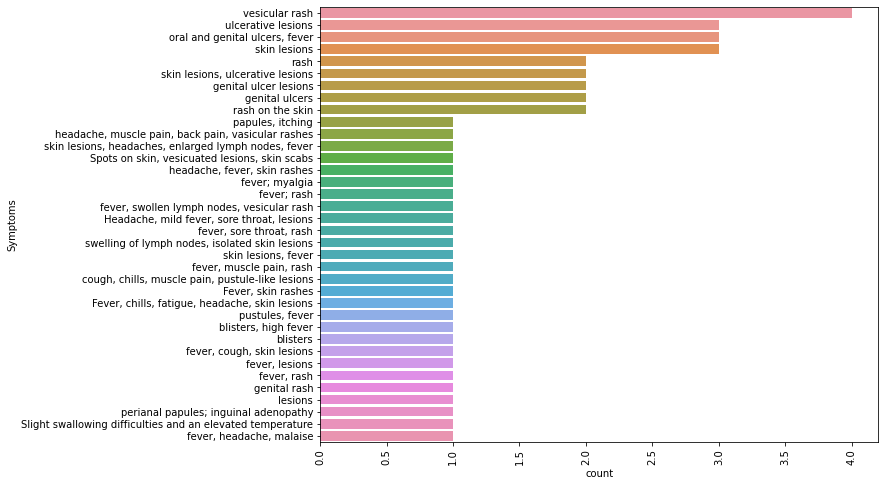

In [13]:
plt.figure(figsize=(10,8))
sns.countplot(y='Symptoms', data=detected, order  = detected['Symptoms'].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

In [14]:
ts_data = detected['Date_confirmation'].value_counts()
ts_data.columns = ['cases']
ts_data.sort_index(inplace=True)
ts_data = pd.DataFrame(ts_data)
ts_data.rename(columns = {'Date_confirmation':'cases'}, inplace = True)
ts_data


,cases
2022-05-06,1
2022-05-12,1
2022-05-13,1
2022-05-15,3
2022-05-17,1
2022-05-18,6
2022-05-19,8
2022-05-20,12
2022-05-21,9
2022-05-23,14


In [15]:
fig = px.line(ts_data, x=ts_data.index, y="cases", width=700, color_discrete_sequence=px.colors.qualitative.Antique)
fig.update_layout(title="Cases", xaxis_title="Days", yaxis_title="Number of Cases",height=700,width=1200)
fig.show()

# Statistics

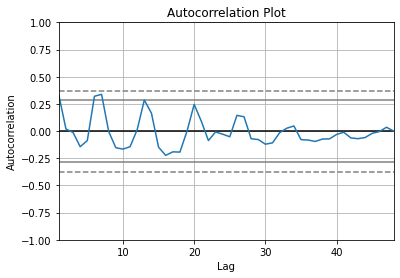

In [16]:
autocorrelation_plot(ts_data)
plt.title("Autocorrelation Plot")
plt.show()

In [17]:
rolling_mean = ts_data.rolling(3).mean()
rolling_std = ts_data.rolling(3).std()

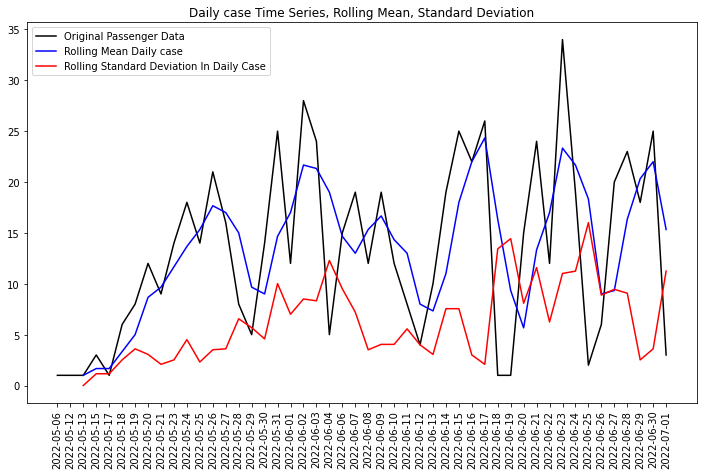

In [18]:
plt.figure(figsize=(12,7))
plt.plot(ts_data, color="black",label="Original Passenger Data")
plt.plot(rolling_mean, color="blue", label="Rolling Mean Daily case")
plt.plot(rolling_std, color="red", label = "Rolling Standard Deviation In Daily Case")
plt.title("Daily case Time Series, Rolling Mean, Standard Deviation")
plt.legend(loc="best")
plt.xticks(rotation=90)
plt.show()

In [19]:
ts_data =np.log(ts_data)

adft = adfuller(ts_data,autolag="AIC")

adft_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(adft_df)

      Values                       Metric
0  -3.993480              Test Statistics
1   0.001445                      p-value
2   5.000000             No. of lags used
3  42.000000  Number of observations used
4  -3.596636          critical value (1%)
5  -2.933297          critical value (5%)
6  -2.604991         critical value (10%)


In [20]:
lag = {'One':1,'two':2,'three':3,'four':4,'Seven':7}
for j,i in lag.items():
    autocorrelation_lag1 = ts_data['cases'].autocorr(lag=i)
    print(f"{j} Month Lag: ", autocorrelation_lag1)

One Month Lag:  0.5085829291661241
two Month Lag:  0.13528552101238064
three Month Lag:  0.0707289009828117
four Month Lag:  -0.04384304813895918
Seven Month Lag:  0.36208546388290674


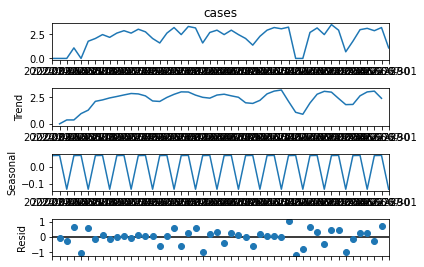

In [21]:
decompose = seasonal_decompose(ts_data['cases'],model='additive', period=3)
decompose.plot()
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
plt.show()

# Forecasting

In [22]:
model = auto_arima(ts_data, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(ts_data)
forecast = model.predict(n_periods=len(ts_data))
forecast = pd.DataFrame(forecast,index = ts_data.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=134.396, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=144.680, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=132.509, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=131.401, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=224.239, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=132.532, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=132.584, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=132.701, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=181.402, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.444 seconds


In [23]:
rms = sqrt(mean_squared_error(ts_data,forecast))
print("RMSE: ", rms)
forecast

RMSE:  1.01699882153965


,Prediction
2022-05-06,1.278215
2022-05-12,2.176027
2022-05-13,2.176027
2022-05-15,2.176027
2022-05-17,2.176027
2022-05-18,2.176027
2022-05-19,2.176027
2022-05-20,2.176027
2022-05-21,2.176027
2022-05-23,2.176027


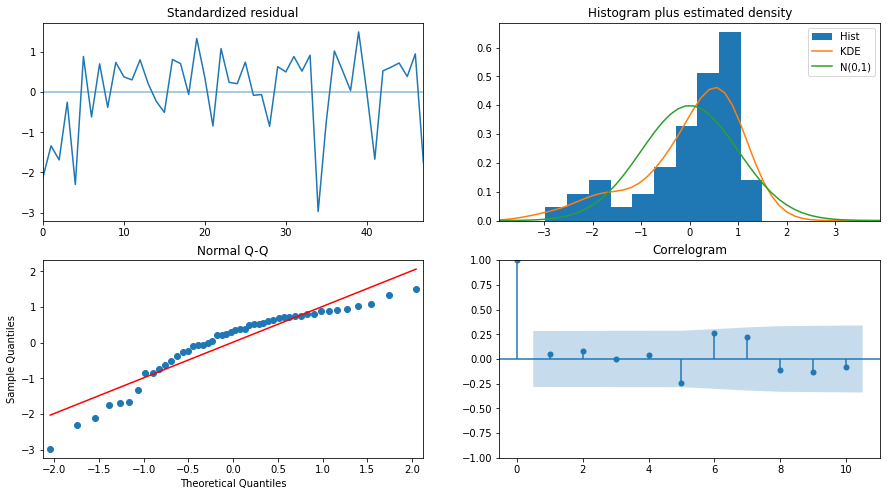

In [24]:
model.plot_diagnostics(figsize=(15,8))
plt.show()